#  Exploratory Data Analysis of Aphex Twin's Music Using Spotify Metrics
# AKA understanding Spotify Metrics through the Music of Aphex Twin's


This notebook analyzes Aphex Twin’s music using Spotify’s audio features. It explores various metrics, such as energy, Valence and Danceability, to understand their relationship with track characteristics and popularity.

The analysis involves calculating custom "Bangerness" and "Ambientness" scores to assess track intensity and atmosphere. Additionally, the analysis examines how features such as energy and acousticness correlate with track popularity.



The initial dataset was compiled using Spotify's API, covering all available Aphex Twin tracks and their associated features. [The code used to generate this dataset can be found here](https://github.com/iftah-og/afx_eda/blob/main/spot_to_df.ipynb).

In [1]:
# Import necessary stuff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

In [2]:
# Load the dataset from the specified URL 
url = 'https://raw.githubusercontent.com/iftah-og/afx_eda/main/afx_c.csv'
df = pd.read_csv(url)
print('df shape is', df.shape)
df.head()


df shape is (118, 18)


,Unnamed: 0,Track Name,Album Name,Track ID,Popularity,Tempo (BPM),Duration (s),Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Release Date
0,0,Digeridoo - 2022 Remaster,Digeridoo (Expanded Edition),2Fh8MjqWLFCoiOOHQRfqgq,40,146.092,432.938,0.519,0.977,10,-8.057,0,0.0544,0.774000,0.855,0.114,0.568,2024-05-31
1,1,Flap Head - 2022 Remaster,Digeridoo (Expanded Edition),24nMZbhkJNqJ70P1J81ZNx,35,136.244,420.766,0.566,0.995,1,-7.022,1,0.0503,0.151000,0.886,0.399,0.592,2024-05-31
2,2,Phloam - 2022 Remaster,Digeridoo (Expanded Edition),2jft0p7lZNXkKksCFHbsKr,32,135.880,333.535,0.525,0.977,10,-8.163,0,0.1310,0.000882,0.440,0.145,0.238,2024-05-31
3,3,Isoprophlex - 2022 Remaster,Digeridoo (Expanded Edition),1U3W1jTqreI3YL84sA1eCx,30,135.609,383.964,0.646,0.914,1,-9.003,0,0.0730,0.234000,0.768,0.039,0.339,2024-05-31
4,4,Digeridoo - Cr7E Version,Digeridoo (Expanded Edition),2Ujum3PkQL0x3QMnGoJGPf,34,142.844,445.314,0.533,0.972,7,-8.425,1,0.0521,0.765000,0.906,0.123,0.415,2024-05-31


## Danceability: is the sole presence of drums enough?

The first thing I wanted to explore was how "Danceability" translates into real-life listening. According to spotify, *"Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."* I sorted the data frame to highlight the most danceable tracks according to Spotify's metrics, and the results were surprising. For instance, I've always appreciated the eerie vibe of **[#8](https://www.youtube.com/watch?v=EBT7KU-WHco)**, but is it really the most danceable track? While danceability is subjective, most people i know wouldn't rank it anywhere near the top. As the initial description suggests, Spotify calculates "Danceability" based on the repetition of patterns throughout a track—and if you know the track in question, you're familiar with the relentless short analog drum loop that never stop. The next track on the list, **[Cow Cud Is A Twin](https://www.youtube.com/watch?v=yETFMyqxR2I)** further supports this idea. Just listen to it — again, there's a repetitive drum loop running throughout the entire track
But does the presence of a drum beat alone make a piece of music genuinely danceable? 

In [3]:
df_dance_pos = df.sort_values(['Danceability'], ascending=False).head()
df_dance_pos [['Album Name', 'Track Name', 'Danceability', 'Tempo (BPM)']]

,Album Name,Track Name,Danceability,Tempo (BPM)
88,Selected Ambient Works Volume II,#8,0.942,112.947
79,...I Care Because You Do,Cow Cud Is A Twin,0.851,79.002
14,Syro,180db_ [130],0.828,130.064
24,Drukqs,Kladfvgbung Mischk,0.816,129.984
12,Syro,produk 29 [101],0.815,101.005


however, Danceability seems to do a good job on the other side of the spectrum, tracks with extreme low Danceability are rather on the ambient side.

In [4]:
df_dance_neg = df.sort_values(['Danceability'], ascending=True).head()
df_dance_neg [['Album Name', 'Track Name', 'Danceability', 'Tempo (BPM)']]

,Album Name,Track Name,Danceability,Tempo (BPM)
102,Selected Ambient Works Volume II,#22,0.064,76.311
90,Selected Ambient Works Volume II,#10,0.105,66.738
100,Selected Ambient Works Volume II,#20,0.108,69.511
80,...I Care Because You Do,Next Heap With,0.109,76.229
94,Selected Ambient Works Volume II,#14,0.124,153.964


## How about the Energy?
Next, I wanted to explore the "Energy" metric. Spotify tells us that it is "*a measure from 0.0 to 1.0 and is comprised from dynamic range, perceived loudness, timbre, onset rate, and general entropy."* Here, too, the results were a bit mixed. For instance, **[Hedphelym](https://www.youtube.com/watch?v=ztKgEnidFUA)** from **Selected Ambient Works 85-92** is a track I really love, and while it does have a certain level of energy, I would personally categorize it more on the ambient side.

In [5]:
df_energy = df.sort_values(['Energy'], ascending=False).head()
df_energy[['Album Name', 'Track Name', 'Energy', 'Tempo (BPM)']]

,Album Name,Track Name,Energy,Tempo (BPM)
115,Selected Ambient Works 85-92,Hedphelym,0.999,124.915
63,Richard D. James Album,Carn Marth,0.997,166.895
1,Digeridoo (Expanded Edition),Flap Head - 2022 Remaster,0.995,136.244
74,...I Care Because You Do,Come On You Slags,0.995,89.614
9,Digeridoo (Expanded Edition),Flap Head - Cr7E Version,0.994,121.014


## Valence: Unexpected Positivity
Spotify's "Valence" metric measures how positive or happy a track sounds, with scores ranging from 0.0 to 1.0. Lower scores supposedly mean the track sounds sad or angry, while higher scores mean it sounds happy or cheerful.
The results for valence are interesting. I get why **[Funny Little Man](https://www.youtube.com/watch?v=aM5ThfUyjEQ)** scores high—it’s weird and fun—but it’s surprising to see **[Bbydhyonchord](https://www.youtube.com/watch?v=IYKajhHfL4Q)** next, as I've always found it more introspective and pensive.

In [6]:
df_valence = df.sort_values(['Valence'], ascending=False).head()
df_valence[['Album Name', 'Track Name', 'Valence', 'Tempo (BPM)']] 

,Album Name,Track Name,Valence,Tempo (BPM)
56,Come To Daddy,Funny Little Man,0.886,132.953
28,Drukqs,Bbydhyonchord,0.883,122.973
69,...I Care Because You Do,Acrid Avid Jam Shred,0.796,80.938
62,Richard D. James Album,Fingerbib,0.787,131.910
20,Syro,s950tx16wasr10 [163.97][earth portal mix],0.743,163.990


# Feature Engineering
The initial metrics provided were somewhat useful but didn't fully capture the characteristics I was interested in. To address this, I decided to create two new features.

**Bangerness** should measures how likely a track is to be banging in  a club setting, focusing on high energy and strong beats. It aims to identify tracks that are particularly suited for a intensive, dance-focused environment.

**Ambientness** should evaluates how soothing and ambient a track is. It considers factors like low energy and high acousticness to determine how calming and atmospheric a track might be.

## Exploring correlation with a heatmap

I started with a heatmap to uncover relationships between track features. This approach reveals correlations between aspects like valence and danceability, which is essential for feature engineering. Knowing these relationships helps in selecting and combining features effectively to capture the music's characteristics.


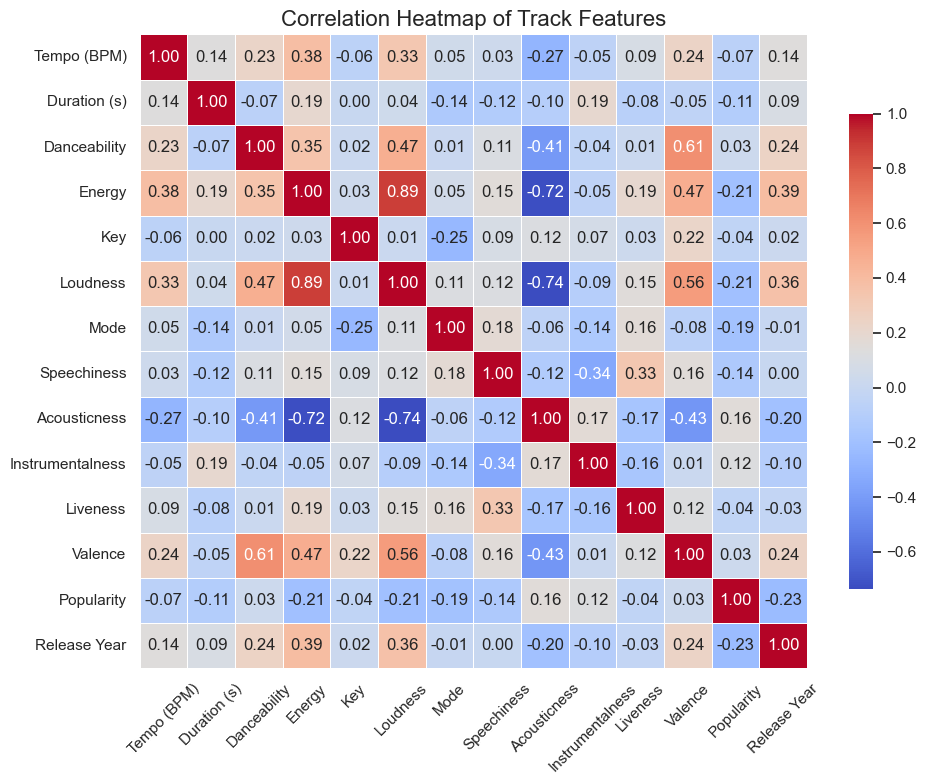

In [7]:
# Convert 'Release Date' to datetime format
df['Release Date'] = pd.to_datetime(df['Release Date'], format='%Y-%m-%d', errors='coerce')

# Extract the year from 'Release Date'
df['Release Year'] = df['Release Date'].dt.year

# Define the list of numeric columns, including the new 'Release Year'
numeric_cols = ['Tempo (BPM)', 'Duration (s)', 'Danceability', 'Energy', 
                'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 
                'Instrumentalness', 'Liveness', 'Valence', 'Popularity', 'Release Year']

# Ensure these columns are numeric
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Set the style of the visualization
sns.set(style='white')

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={"shrink": .75})

# Add titles and labels
plt.title('Correlation Heatmap of Track Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()


As we can see in the heatmap above, certain patterns immediately stand out. For example, there is a very strong relationship between loudness and energy (which is not surprising, as Spotify indicates that loudness is one of the features used to measure energy), as well as between valence and danceability. Additionally, there is a very strong negative relationship between energy, acousticness, and loudness.

What also stands out is the moderate correlation between release year and loudness. There are two reasons for this: firstly, releases after 2014 tend to be less ambient, and secondly, if you have been in the audio world for a while, you might be familiar with the term "The loudness war."

The plot below shows a clear trend. We need to factor this in when calculating "Bangerness" to ensure our results reflect the data correctly. Since loudness is used to calculate energy, this could make newer releases seem more "banging.

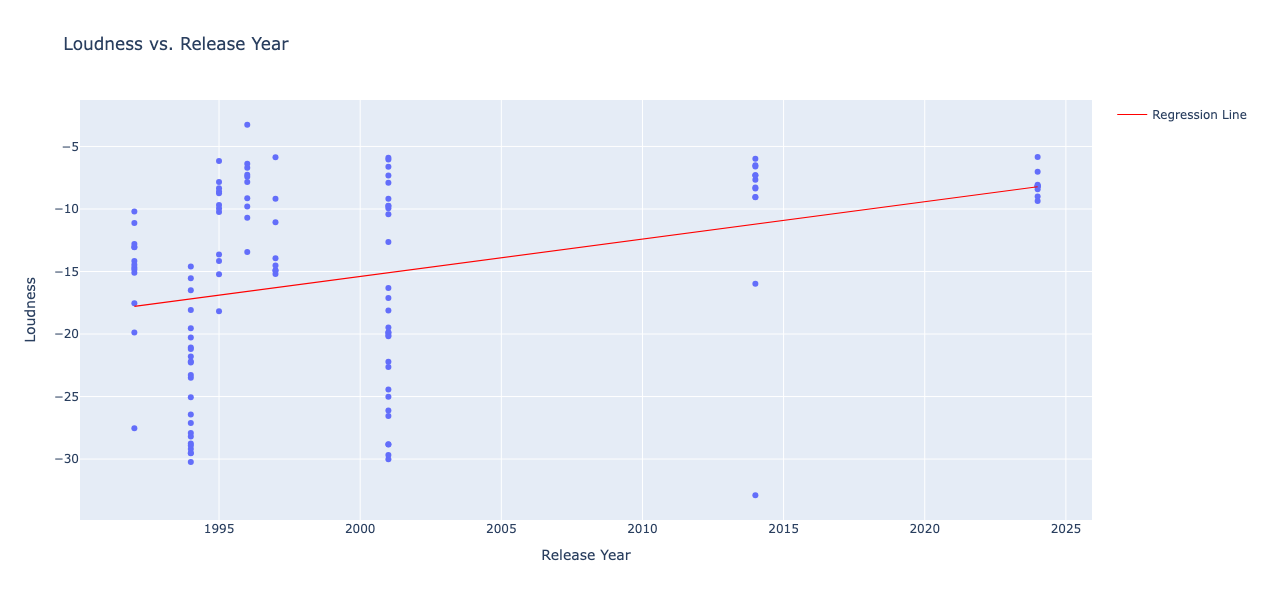

In [28]:
df['Release Year'] = df['Release Date'].dt.year

# Prepare the data
df['Release Year'] = df['Release Date'].dt.year
X = df[['Release Year']].dropna()  
y = df['Loudness'].dropna()  

# Fit 
model = LinearRegression()
model.fit(X, y)

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Release Year': X['Release Year'],
    'Loudness': y,
    'Track Name': df['Track Name']  
})


fig = px.scatter(df_plot,
                 x='Release Year',
                 y='Loudness',
                 hover_name='Track Name',  # Display track name on hover
                 labels={'Release Year': 'Release Year', 'Loudness': 'Loudness'},
                 title='Loudness vs. Release Year')


fig.add_scatter(x=X['Release Year'],
                y=model.predict(X),
                mode='lines',
                line=dict(color='red', width=1.2),
                name='Regression Line')

# Update the layout to make the plot larger
fig.update_layout(
    width=1000,  
    height=600,  
    xaxis_title='Release Year',
    yaxis_title='Loudness',
    title='Loudness vs. Release Year'
)

fig.show()

To calculate "Bangerness," I use energy, valence, danceability, and negative acousticness. Loudness is adjusted to have more influence on older tracks. I apply intuitive weights to these factors based on insights gained from the dataset. The calculation is:

**Bangerness = (3.6×Energy) + (0.1×Valence) + (0.6×Danceability) + (0.1×AdjustedLoudnessWeight×Loudness) − (0.2×Acousticness)**



In [9]:
# Convert 'Release Date' to a numeric format
df['Release Date Numeric'] = df['Release Date'].apply(lambda x: x.timestamp() if pd.notnull(x) else pd.NA)

# Normalize 'Release Date'
df['ReleaseDateNorm'] = (df['Release Date Numeric'] - df['Release Date Numeric'].min()) / (df['Release Date Numeric'].max() - df['Release Date Numeric'].min())

# Calculate the weight for Loudness
df['AdjustedLoudnessWeight'] = 1 - df['ReleaseDateNorm']

# Calculate the raw Bangerness score with adjusted Loudness weight
df['Bangerness'] = (3.6 * df['Energy'] +
                    0.1 * df['Valence'] +
                    0.6 * df['Danceability'] +
                    0.1 * df['AdjustedLoudnessWeight'] * df['Loudness']) - 0.2 * df['Acousticness']

# Normalize the Bangerness score 
min_bangerness = df['Bangerness'].min()
max_bangerness = df['Bangerness'].max()
df['Bangerness'] = (df['Bangerness'] - min_bangerness) / (max_bangerness - min_bangerness)

# Sort DataFrame 
df_sorted = df.sort_values(['Bangerness'], ascending=False)

# Clean Up
df_sorted = df_sorted.drop(columns=['ReleaseDateNorm', 'AdjustedLoudnessWeight', 'Release Date Numeric'])

# Remove Duplicate from the list
df_sorted['First Word'] = df_sorted['Track Name'].str.split().str[0]
df_sorted_unique = df_sorted.drop_duplicates(subset='First Word', keep='first')
df_sorted_unique = df_sorted_unique.drop(columns=['First Word'])

# Display the top 10 tracks 
df_sorted_unique[['Album Name', 'Track Name','Tempo (BPM)', 'Release Date', 'Instrumentalness', 
                  'Popularity', 'Danceability', 'Energy', 'Valence', 'Loudness', 
                  'Acousticness', 'Bangerness']].head(10)

,Album Name,Track Name,Tempo (BPM),Release Date,Instrumentalness,Popularity,Danceability,Energy,Valence,Loudness,Acousticness,Bangerness
9,Digeridoo (Expanded Edition),Flap Head - Cr7E Version,121.014,2024-05-31,0.937,24,0.675,0.994,0.552,-5.840,0.17400,1.000000
7,Digeridoo (Expanded Edition),Phloam - Cr7E Version,132.169,2024-05-31,0.477,24,0.536,0.979,0.191,-8.182,0.00102,0.979356
5,Digeridoo (Expanded Edition),"Digeridoo - Cr7E Version, Live In Cornwall",142.803,2024-05-31,0.900,26,0.525,0.986,0.370,-8.186,0.55500,0.968315
63,Richard D. James Album,Carn Marth,166.895,1996-11-04,0.747,34,0.599,0.997,0.585,-3.264,0.05250,0.957530
17,Syro,CIRCLONT14 [152.97][shrymoming mix],152.969,2014-09-22,0.928,34,0.671,0.978,0.178,-7.304,0.27900,0.949845
3,Digeridoo (Expanded Edition),Isoprophlex - 2022 Remaster,135.609,2024-05-31,0.768,30,0.646,0.914,0.339,-9.003,0.23400,0.949663
20,Syro,s950tx16wasr10 [163.97][earth portal mix],163.990,2014-09-22,0.871,36,0.686,0.920,0.743,-5.977,0.17200,0.937644
19,Syro,PAPAT4 [155][pineal mix],155.019,2014-09-22,0.917,34,0.668,0.914,0.663,-6.606,0.39300,0.922267
36,Drukqs,54 Cymru Beats,168.012,2001-10-22,0.694,35,0.632,0.967,0.390,-6.048,0.01640,0.921096
23,Drukqs,Vordhosbn,170.071,2001-10-22,0.865,44,0.662,0.960,0.605,-6.619,0.04790,0.916346


Above, you can find the top 10 tracks with the highest "Bangerness" score according to my calculation. Here's a link to the playlist:

Listen to the Playlist

# Popularity

The analysis below shows a slight decline in popularity as the "Bangerness" score increases. Although the Mean Squared Error of 87.35 suggests a high level of prediction error, the overall trend still offers useful insight. It indicates that tracks with higher "Bangerness" don’t always become more popular. This aligns with my hunch that Spotify is often used for background music, which might explain why more energetic or demanding tracks aren’t as popular. (Can you imagine something like **[Phloam](https://www.youtube.com/watch?v=k034En2FVoo)** being featured in a playlist called "10 Tracks to Study and Focus On a Rainy Day"?)

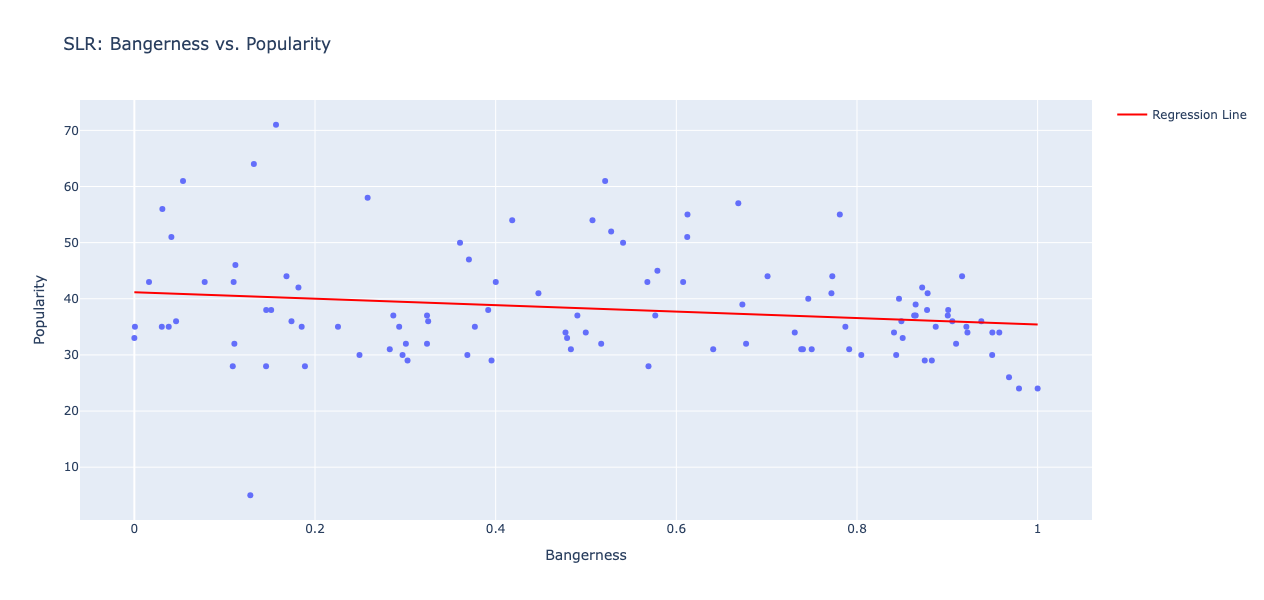

Coefficient (Slope): -5.754513340651884
Intercept: 41.17276479921264
Mean Squared Error (MSE): 90.05093730462856


In [34]:
# Reshape data for SLR
X = df_sorted_unique[['Bangerness']].values.reshape(-1, 1)
y = df_sorted_unique['Popularity'].values

# Perform SLR
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Bangerness': X.flatten(),
    'Popularity': y,
    'Predicted Popularity': y_pred,
    'Track Name': df_sorted_unique['Track Name']  # Assuming 'Track Name' is available
})

# Plot with Plotly
import plotly.express as px

fig = px.scatter(df_plot,
                 x='Bangerness',
                 y='Popularity',
                 title='SLR: Bangerness vs. Popularity',
                 hover_data={'Bangerness': True, 'Popularity': True, 'Track Name': True})

fig.add_scatter(x=df_plot['Bangerness'],
                y=df_plot['Predicted Popularity'],
                mode='lines',
                line=dict(color='red', width=2),
                name='Regression Line')

fig.update_layout(
    width=1000,
    height=600,
    xaxis_title='Bangerness',
    yaxis_title='Popularity'
)

fig.show()

# Print SLR results
print(f"Coefficient (Slope): {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
print(f"Mean Squared Error (MSE): {np.mean((y_pred - y) ** 2)}")


I want to confirm my hunch by looking into the most popular tracks. As shown below, my assumption seems to hold up, with tracks like "QKThr," "Avril 14th," and "rhubarb (#3)" leading the list. It’s likely that these tracks found their way into a large number of playlists, which in turn contributed to their popularity.

In [11]:
df_sorted = df.sort_values(['Popularity'], ascending=False)
df_sorted.head(10)
df_sorted[['Track Name', 'Popularity',  
            'Danceability','Release Date', 'Bangerness']].head(10)

,Track Name,Popularity,Danceability,Release Date,Bangerness
39,QKThr,71,0.451,2001-10-22,0.156822
30,Avril 14th,64,0.558,2001-10-22,0.132297
105,Xtal,61,0.510,1992-02-10,0.521199
83,#3,61,0.159,1994-03-07,0.053873
21,aisatsana [102],58,0.260,2014-09-22,0.258259
52,Flim,57,0.710,1997-10-06,0.668602
109,I,56,0.183,1992-02-10,0.031016
78,Alberto Balsalm,55,0.791,1995-04-24,0.612349
14,180db_ [130],55,0.828,2014-09-22,0.780980
107,Pulsewidth,54,0.765,1992-02-10,0.507184


# What makes it popular?


I wanted to analyze some features of the top 10 tracks to see if there are any patterns. So, I plotted Energy, Acousticness, Instrumentalness, and Speechiness against Popularity. The graph shows that these top tracks generally have low energy, high acousticness and high instrumentalness. Danceability, however, shows more mixed results.

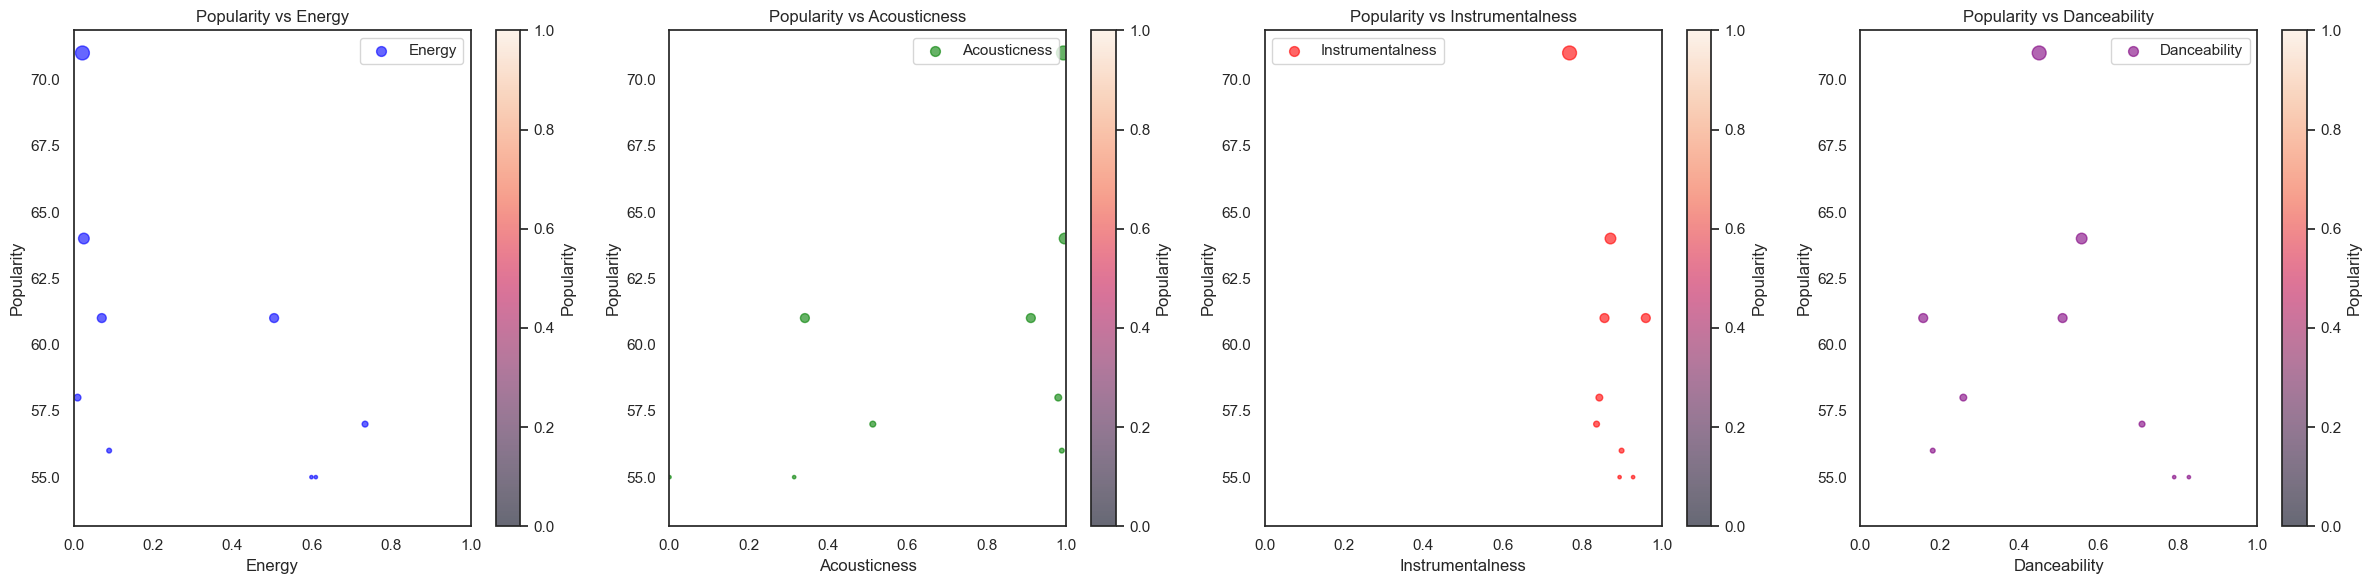

In [12]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Prepare the data
df_pop = df_sorted.head(10)
X = df_pop[['Energy', 'Acousticness', 'Instrumentalness', 'Danceability']].values
y = df_pop['Popularity'].values

# Scale features
X = scaler.fit_transform(X)

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Scaling for dot sizes
popularity_scaled = (y - y.min()) / (y.max() - y.min()) * 100  # Scale to range 0-100

# Plotting
plt.figure(figsize=(24, 6))  # Adjusted figure size

# Scatter plot for Energy vs Popularity
plt.subplot(1, 4, 1)
plt.scatter(df_pop['Energy'], y, c='blue', s=popularity_scaled, alpha=0.6, label='Energy')
plt.xlabel('Energy')
plt.ylabel('Popularity')
plt.title('Popularity vs Energy')
plt.colorbar(label='Popularity')
plt.legend()
plt.xlim(0, 1)  # Set x-axis from 0 to 1

# Scatter plot for Acousticness vs Popularity
plt.subplot(1, 4, 2)
plt.scatter(df_pop['Acousticness'], y, c='green', s=popularity_scaled, alpha=0.6, label='Acousticness')
plt.xlabel('Acousticness')
plt.ylabel('Popularity')
plt.title('Popularity vs Acousticness')
plt.colorbar(label='Popularity')
plt.legend()
plt.xlim(0, 1)  # Set x-axis from 0 to 1

# Scatter plot for Instrumentalness vs Popularity
plt.subplot(1, 4, 3)
plt.scatter(df_pop['Instrumentalness'], y, c='red', s=popularity_scaled, alpha=0.6, label='Instrumentalness')
plt.xlabel('Instrumentalness')
plt.ylabel('Popularity')
plt.title('Popularity vs Instrumentalness')
plt.colorbar(label='Popularity')
plt.legend()
plt.xlim(0, 1)  # Set x-axis from 0 to 1

# Scatter plot for Danceability vs Popularity
plt.subplot(1, 4, 4)
plt.scatter(df_pop['Danceability'], y, c='purple', s=popularity_scaled, alpha=0.6, label='Danceability')
plt.xlabel('Danceability')
plt.ylabel('Popularity')
plt.title('Popularity vs Danceability')
plt.colorbar(label='Popularity')
plt.legend()
plt.xlim(0, 1)  # Set x-axis from 0 to 1

plt.tight_layout()
plt.show()


# Engineering Ambientness

To calculate the Ambientness score, I invert the scales for Energy and Danceability so that lower values have a positive impact. Then, I combine these inverted values with the actual values of Acousticness Instrumentalness and Valence. The final score is weighted to reflect the contribution of each feature to a track's ambient quality, using an intuitive weighting approach similar to how I handled Bangerness.

Ambientness=(0.4×Energy_inverse)+(0.3×Acousticness)+(0.4×Instrumentalness)+(0.1×Danceability_inverse)+(0.1×Valence)








In [13]:
# Invert the scales where lower values should contribute positively to Ambientness
df_sorted_unique['Energy_inverse'] = 1 - df_sorted_unique['Energy']
df_sorted_unique['Danceability_inverse'] = 1 - df_sorted_unique['Danceability']

# Calculate the Ambientness score
df_sorted_unique['Ambientness'] = (
    0.4 * df_sorted_unique['Energy_inverse'] +    
    0.3 * df_sorted_unique['Acousticness'] +      
    0.4 * df_sorted_unique['Instrumentalness'] +  
    0.1 * df_sorted_unique['Danceability_inverse'] +
    0.1 * df_sorted_unique['Valence']

)

# Normalize the Ambientness score to the range [0, 1]
min_ambientness = df_sorted_unique['Ambientness'].min()
max_ambientness = df_sorted_unique['Ambientness'].max()
df_sorted_unique['Ambientness'] = (df_sorted_unique['Ambientness'] - min_ambientness) / (max_ambientness - min_ambientness)

# Display the DataFrame with the new Ambientness column
df_sorted_unique[['Track Name', 'Energy', 'Acousticness', 'Instrumentalness', 
                  'Danceability', 'Ambientness']].head(20)

# Sort by Ambientness and display the top tracks
df_amb = df_sorted_unique.sort_values(['Ambientness'], ascending=False)
df_amb[['Album Name', 'Track Name', 'Popularity', 'Energy', 'Acousticness', 'Instrumentalness', 
       'Danceability', 'Bangerness', 'Valence', 'Ambientness']].head(10)


,Album Name,Track Name,Popularity,Energy,Acousticness,Instrumentalness,Danceability,Bangerness,Valence,Ambientness
87,Selected Ambient Works Volume II,#7,43,0.03330,0.994,0.981,0.161,0.016226,0.0481,1.000000
94,Selected Ambient Works Volume II,#14,35,0.02960,0.992,0.946,0.124,0.000628,0.0377,0.989705
45,Drukqs,Petiatil Cx Htdui,43,0.00682,0.996,0.956,0.421,0.109923,0.1390,0.984530
86,Selected Ambient Works Volume II,#6,35,0.07740,0.995,0.979,0.226,0.038044,0.0675,0.977657
41,Drukqs,Bit 4,5,0.02320,0.972,0.930,0.181,0.128393,0.0000,0.970699
100,Selected Ambient Works Volume II,#20,51,0.04190,0.971,0.909,0.108,0.041007,0.0429,0.966181
90,Selected Ambient Works Volume II,#10,33,0.04720,0.974,0.905,0.105,0.000000,0.0201,0.961457
26,Drukqs,Strotha Tynhe,38,0.00250,0.990,0.894,0.384,0.151476,0.0373,0.953681
30,Drukqs,Avril 14th,64,0.02590,0.996,0.871,0.558,0.132297,0.3700,0.952805
43,Drukqs,Father,30,0.03210,0.990,0.951,0.698,0.249236,0.2030,0.949872


Mean Squared Error: 0.013151429053239065
R² Score: 0.8003806142159512


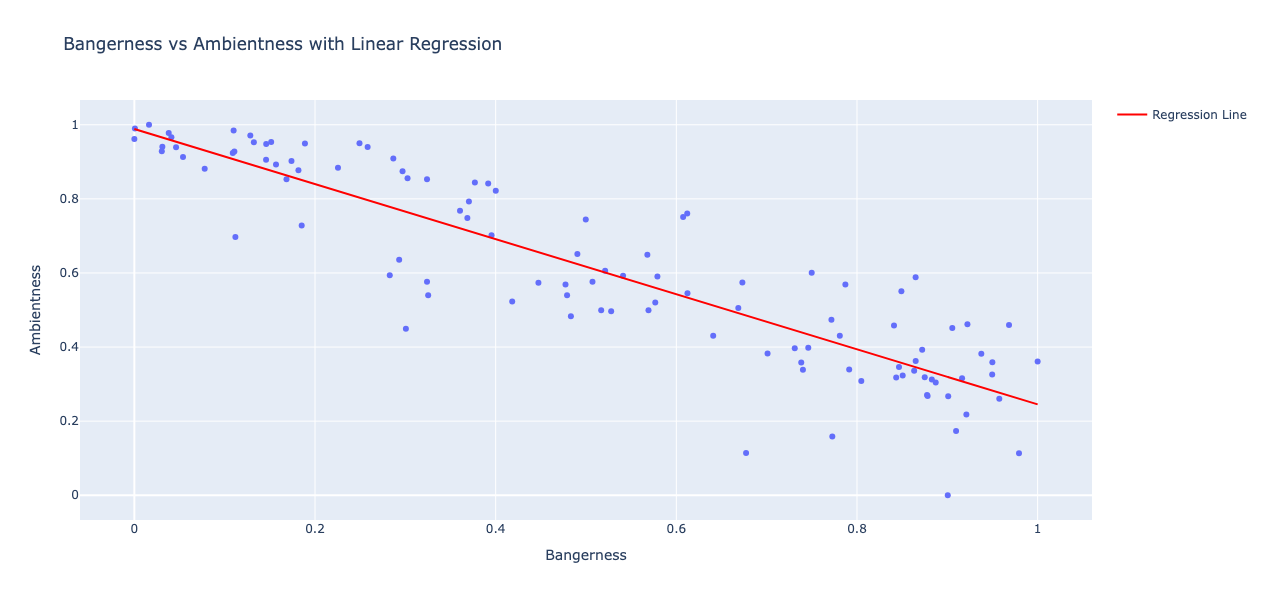

In [36]:
# Prepare the data
X = df_amb['Bangerness'].values.reshape(-1, 1)
y = df_amb['Ambientness'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict and evaluate
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Data for the plot
df_plot = pd.DataFrame({
    'Bangerness': df_amb['Bangerness'],
    'Ambientness': df_amb['Ambientness'],
    'Track Name': df_amb['Track Name'],
    'Predicted Ambientness': y_pred
})

# Interactive plot
import plotly.express as px

fig = px.scatter(df_plot,
                 x='Bangerness',
                 y='Ambientness',
                 hover_name='Track Name',
                 labels={'Bangerness': 'Bangerness', 'Ambientness': 'Ambientness'},
                 title='Bangerness vs Ambientness with Linear Regression')

fig.add_scatter(x=df_plot['Bangerness'],
                y=df_plot['Predicted Ambientness'],
                mode='lines',
                line=dict(color='red', width=2),
                name='Regression Line')

fig.update_layout(
    width=1000, 
    height=600,
    xaxis_title='Bangerness',
    yaxis_title='Ambientness'
)

fig.show()

The linear regression analysis between Bangerness and Ambientness shows an R² score of 0.80, meaning there's a strong link between them. The Mean Squared Error of 0.013 shows that the model's predictions are quite accurate. This tells us that Bangerness does a good job of predicting Ambientness, and the model captures most of the variation in Ambientness based on Bangerness.

# Where Bangerness Meets Ambientness

Finally, I couldn’t help but wonder what happens when Bangerness and Ambientness come together. I filtered the tracks to find those where the two scores are within 7% of each other. [Here is a playlist with tracks that hit this balance]():

This final step shows tracks where Bangerness and Ambientness are closely aligned, and I find that the results really make sense.

In [46]:
df_fin = df_amb[['Album Name', 'Track Name', 'Popularity', 'Energy', 'Danceability', 'Acousticness', 'Instrumentalness', 
                 'Speechiness', 'Liveness', 'Valence', 'Bangerness', 'Ambientness']]

# Look for tracks with 7% or less difference between Bangerness and Ambientness
df_fin_filtered = df_fin[
    (df_fin['Bangerness'] - df_fin['Ambientness']).abs() < 0.07
]

df_fin_filtered

,Album Name,Track Name,Popularity,Energy,Danceability,Acousticness,Instrumentalness,Speechiness,Liveness,Valence,Bangerness,Ambientness
111,Selected Ambient Works 85-92,Heliosphan,50,0.612,0.345,0.455000,0.956,0.0416,0.0854,0.1260,0.541024,0.592726
112,Selected Ambient Works 85-92,We Are the Music Makers,45,0.574,0.723,0.398000,0.942,0.0644,0.1350,0.5580,0.579056,0.590659
107,Selected Ambient Works 85-92,Pulsewidth,54,0.486,0.765,0.420000,0.876,0.0724,0.3320,0.3030,0.507184,0.576585
78,...I Care Because You Do,Alberto Balsalm,55,0.599,0.791,0.315000,0.928,0.1450,0.1110,0.5700,0.612349,0.545285
70,...I Care Because You Do,The Waxen Pith,33,0.423,0.541,0.077400,0.903,0.0316,0.1180,0.3720,0.479071,0.539695
24,Drukqs,Kladfvgbung Mischk,37,0.544,0.816,0.551000,0.741,0.1050,0.1080,0.1620,0.576695,0.520384
76,...I Care Because You Do,Wet Tip Hen Ax,28,0.416,0.677,0.103000,0.879,0.0323,0.1240,0.0919,0.569185,0.499606
33,Drukqs,Orban Eq Trx 4,32,0.275,0.776,0.000006,0.795,0.0584,0.1030,0.2690,0.516815,0.499323
58,Come To Daddy,IZ-US,52,0.459,0.581,0.039800,0.881,0.0314,0.1510,0.3160,0.527848,0.496309
92,Selected Ambient Works Volume II,#12,31,0.482,0.234,0.000279,0.850,0.1480,0.1690,0.1720,0.483278,0.483360
